In [ ]:
# default_exp sparsifier

# Sparsifier

> Make your neural network sparse

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
#hide
from fastai.vision.all import *

import torch
import torch.nn as nn
from torchvision.utils import make_grid

%config InlineBackend.figure_format = 'retina'

Let's start by creating a model

In [ ]:
model = resnet18()

In [ ]:
def plot_kernels(layer, save=None):
    kernels = layer.weight.detach().clone()
    kernels = kernels - kernels.min()
    kernels = kernels/kernels.max()
    
    plt.figure(figsize=(10,10))
    img = make_grid(kernels, nrow=8, padding=1)
    plt.imshow(img.detach().permute(1,2,0).cpu())
    if save: plt.savefig(f'{save}.pdf')

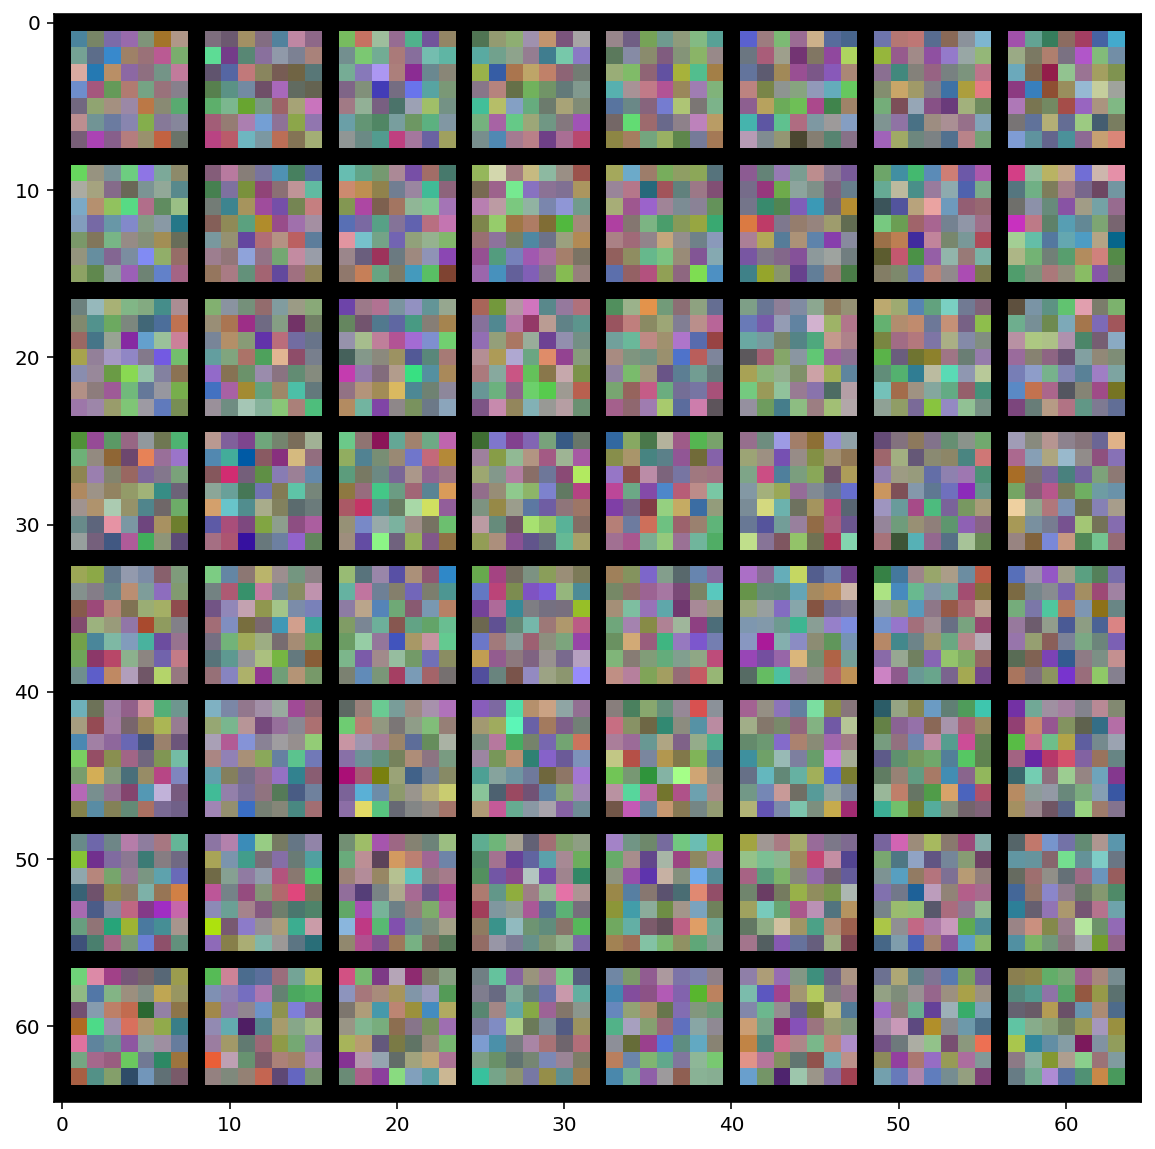

In [ ]:
plot_kernels(model.conv1)

In [ ]:
#export
class Sparsifier():
    '''
    Make a neural network sparse using the `prune` method
    '''
    def __init__(self, model, granularity, method, criteria):
        store_attr()
        self._save_weights() # Save the original weights
        
    def prune(self, sparsity):
        for k, m in enumerate(self.model.modules()):
            if isinstance(m, nn.Conv2d):
                weight = self.criteria(m, self.granularity)
                mask = self._compute_mask(self.model, weight, sparsity)
                m.register_buffer("_mask", mask) # Put the mask into a buffer
                self._apply(m) 
            
    def _apply(self, module):
        '''
        Apply the mask and freeze the gradient so the corresponding weights are not updated anymore
        '''
        mask = getattr(module, "_mask")
        module.weight.data.mul_(mask)

        if self.granularity == 'filter': # If we remove complete filters, we want to remove the bias as well
            if module.bias is not None:
                module.bias.data.mul_(mask.squeeze())
                if module.bias.grad is not None: # In case some layers are freezed
                    module.bias.grad.mul_(mask.squeeze())
    
    def mask_grad(self):
        for k, m in enumerate(self.model.modules()):
            if isinstance(m, nn.Conv2d):
                mask = getattr(m, "_mask")
                if m.weight.grad is not None: # In case some layers are freezed
                    m.weight.grad.mul_(mask)

                if self.granularity == 'filter': # If we remove complete filters, we want to remove the bias as well
                        if m.bias.grad is not None: # In case some layers are freezed
                            m.bias.grad.mul_(mask.squeeze())
        
    
    def _reset_weights(self):
        for k, m in enumerate(self.model.modules()):
            if isinstance(m, nn.Linear):
                init_weights = getattr(m, "_init_weights")
                m.weight.data = init_weights.clone()
            if isinstance(m, nn.Conv2d):
                init_weights = getattr(m, "_init_weights")
                m.weight.data = init_weights.clone()
                self._apply(m) # Reset the weights and apply the current mask
                
    def _save_weights(self):
        for k, m in enumerate(self.model.modules()):
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                m.register_buffer("_init_weights", m.weight.clone())
                
    def _clean_buffers(self):
        for k, m in enumerate(self.model.modules()):
            if isinstance(m, nn.Conv2d):
                del m._buffers["_mask"]

            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                del m._buffers["_init_weights"]                
                    
    
    def _compute_mask(self, model, weight, sparsity):
        '''
        Compute the binary masks
        '''
        if self.method == 'global':
            global_weight = []
            
            for k, m in enumerate(model.modules()):
                if isinstance(m, nn.Conv2d):
                    w = self.criteria(m, self.granularity)
                    global_weight.append(w)

            global_weight = torch.cat([i.view(-1) for i in global_weight])
            threshold = torch.quantile(global_weight, sparsity/100) # Compute the threshold globally
            
        elif self.method == 'local': 
            threshold = torch.quantile(weight.view(-1), sparsity/100) # Compute the threshold locally
            
        else: raise NameError('Invalid Method')
            
        # Make sure we don't remove every weight of a given layer
        if threshold > weight.max(): threshold = weight.max()

        mask = weight.ge(threshold).to(dtype=weight.dtype)

        return mask

In [ ]:
show_doc(Sparsifier.prune)

<h4 id="Sparsifier.prune" class="doc_header"><code>Sparsifier.prune</code><a href="__main__.py#L6" class="source_link" style="float:right">[source]</a></h4>

> <code>Sparsifier.prune</code>(**`sparsity`**)



In [ ]:
def l1_norm(m, granularity):

    if granularity == 'weight':
        w = m.weight.abs()

    elif granularity == 'vector':
        dim = 3 # dim=1 -> channel vector, dim=2 -> column vector, dim=3 -> row vector
        w = (torch.norm(m.weight, p=1, dim=dim)/(m.weight.shape[3])).unsqueeze(dim) # Normalize the norm to be consistent for different dimensions

    elif granularity == 'kernel':
        w = (torch.norm(m.weight, p=1, dim=(2,3))/(m.weight.shape[2:].numel()))[:,:, None, None]

    elif granularity == 'filter':       
        w = (torch.norm(m.weight, p=1, dim=(1,2,3))/(m.weight.shape[1:].numel()))[:, None, None, None]

    else: raise NameError('Invalid Granularity')

    return w

## Pruning individual weights

In [ ]:
model = resnet18()
pruner = Sparsifier(model, 'weight', 'local', l1_norm)
pruner.prune(80)

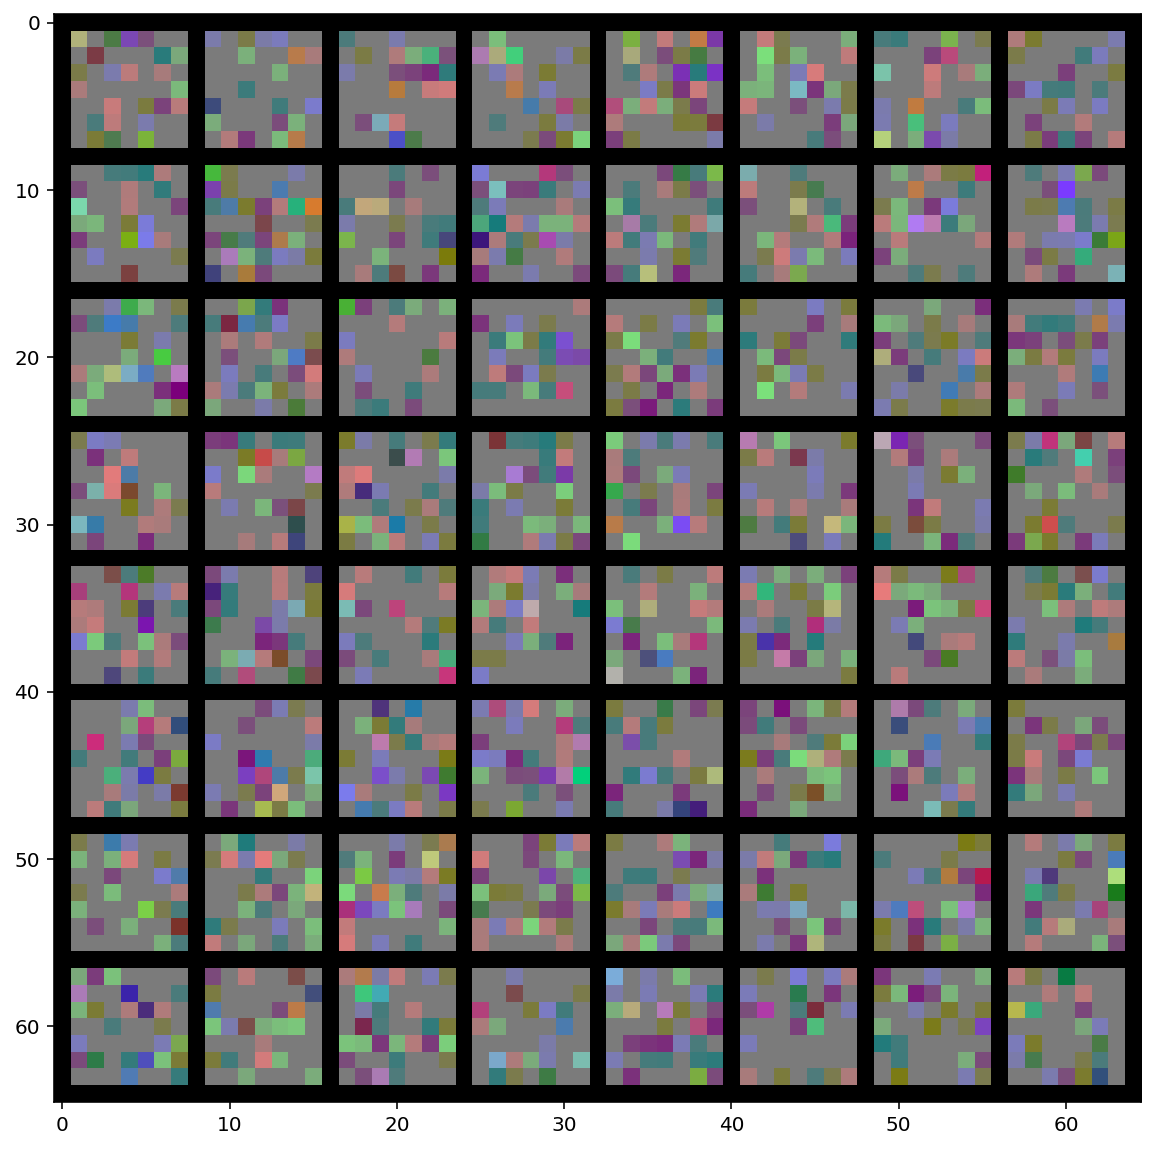

In [ ]:
plot_kernels(model.conv1)

## Pruning Vectors of weights

In [ ]:
model = resnet18()
pruner = Sparsifier(model, 'vector', 'local', l1_norm)
pruner.prune(80)

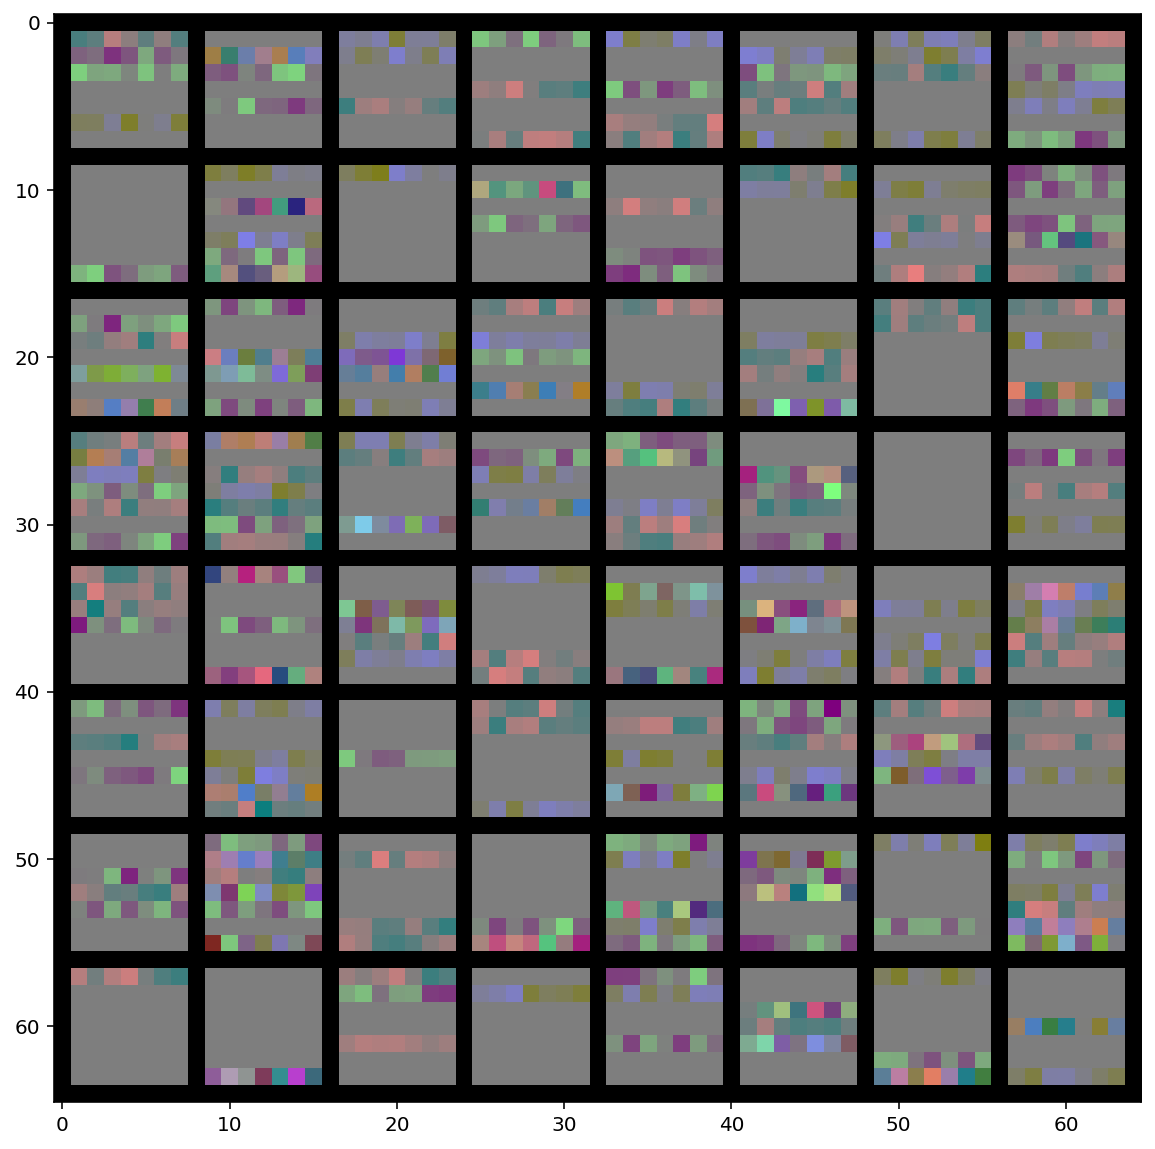

In [ ]:
plot_kernels(model.conv1)

## Pruning Kernels

In [ ]:
model = resnet18()
pruner = Sparsifier(model, 'kernel', 'local', l1_norm)
pruner.prune(80)

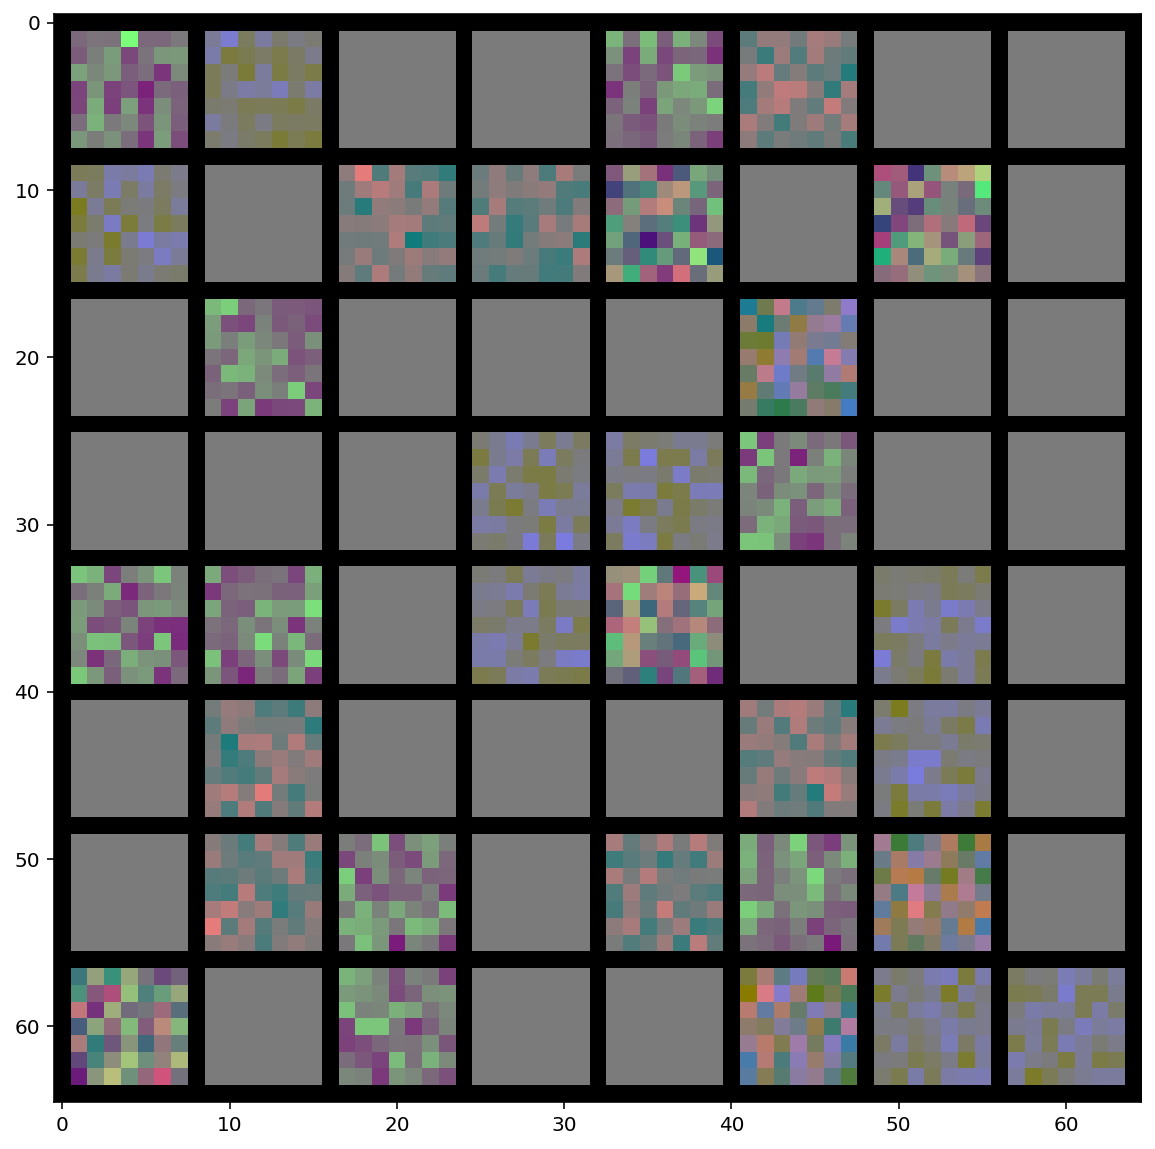

In [ ]:
plot_kernels(model.conv1)

## Pruning Filters

In [ ]:
model = resnet18()
pruner = Sparsifier(model, 'filter', 'local', l1_norm)
pruner.prune(80)

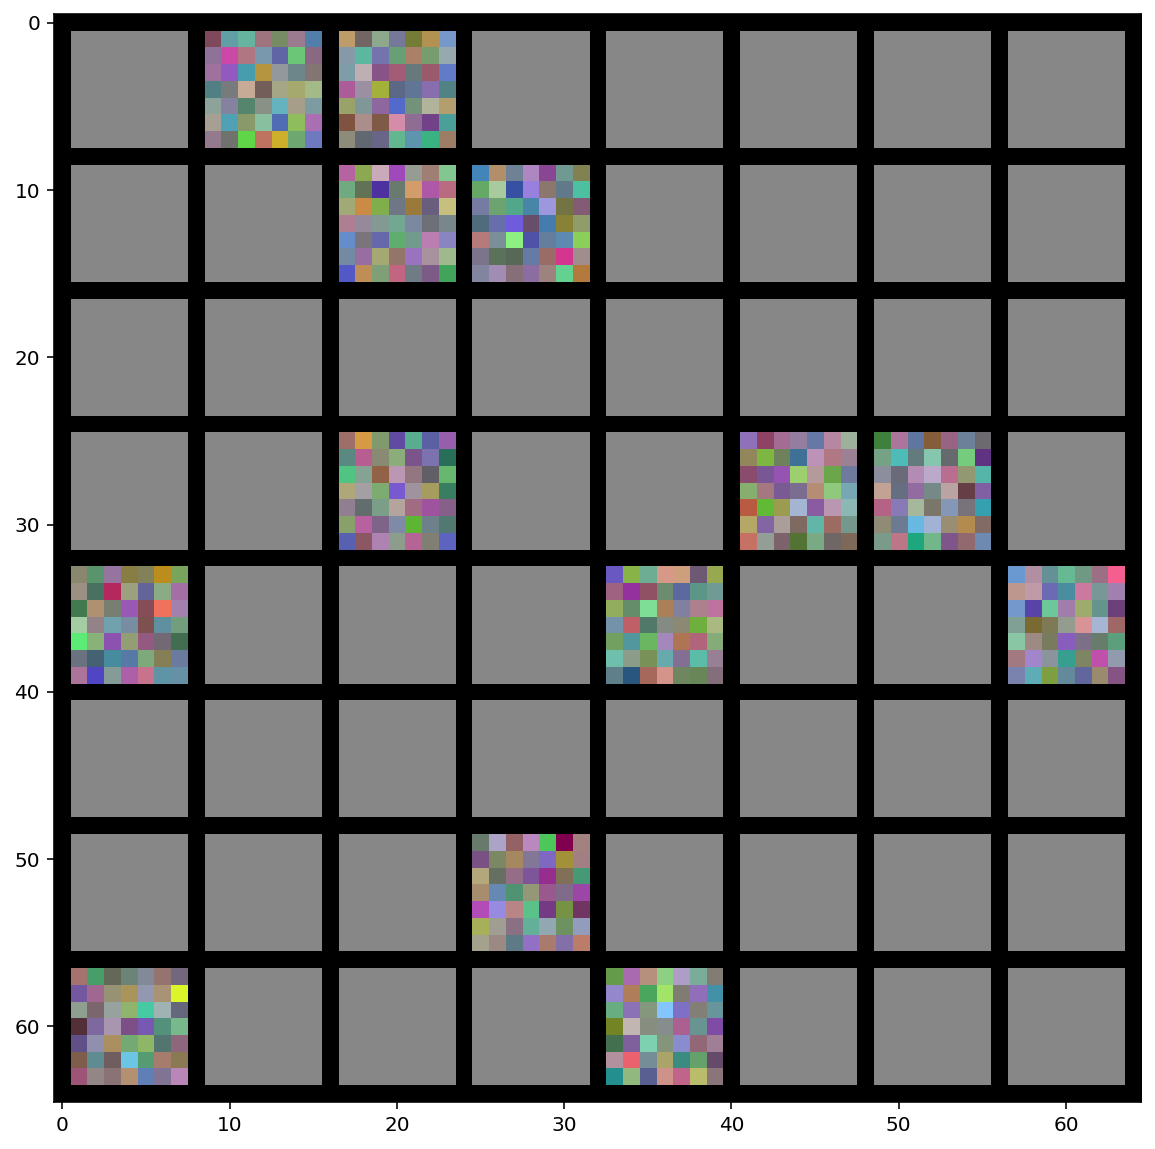

In [ ]:
plot_kernels(model.conv1)